In [82]:
import os
import pathlib
from src.data.data_utils import get_mlb_db_engine

engine = get_mlb_db_engine()

team_map_df = pd.read_csv(os.path.join(pathlib.Path.home(), 'sports', 'mlb_simulator', 'data', 'raw', 'team_id_map.csv'))
team_map_df.to_sql('TeamIdMapping', engine, if_exists='replace', index=False)

30

In [20]:
import statsapi
from datetime import datetime

def get_venue(team_id):
    todays_date = datetime.now().strftime('%Y-%m-%d')
    todays_games = statsapi.schedule(date=todays_date)

    for game in todays_games:
        if game['away_id'] == team_id or game['home_id'] == team_id:
            return game['venue_id'], game['venue_name']

get_venue(147)

(3313, 'Yankee Stadium')

In [23]:
import statsapi
from datetime import datetime, timedelta

#print(datetime.now()#
todays_date = (datetime.now() + timedelta(days=0)).strftime('%Y-%m-%d')
print(todays_date)
#todays_games = statsapi.schedule(date=todays_date)

2024-05-23


In [19]:
todays_games[1]

{'game_id': 745741,
 'game_datetime': '2024-05-23T16:35:00Z',
 'game_date': '2024-05-23',
 'game_type': 'R',
 'status': 'In Progress',
 'away_name': 'Seattle Mariners',
 'home_name': 'New York Yankees',
 'away_id': 136,
 'home_id': 147,
 'doubleheader': 'N',
 'game_num': 1,
 'home_probable_pitcher': 'Luis Gil',
 'away_probable_pitcher': 'Luis Castillo',
 'home_pitcher_note': '',
 'away_pitcher_note': '',
 'away_score': 0,
 'home_score': 2,
 'current_inning': 4,
 'inning_state': 'Top',
 'venue_id': 3313,
 'venue_name': 'Yankee Stadium',
 'national_broadcasts': ['MLBN (out-of-market only)'],
 'series_status': 'SEA leads 2-1',
 'summary': '2024-05-23 - Seattle Mariners (0) @ New York Yankees (2) (Top of the 4th)'}

## Features:
 - outs, on_1b, on_2b, on_3b, launch_speed, launch_angle, spray_angle, batter_speed, fielder_positioning, OAA_for_batter_handedness (for current game yr, standardized)

In [122]:
import pandas as pd
import numpy as np
import xgboost as xgb
from src.data.data_utils import query_mlb_db
from src.features import build_features as f
from importlib import reload
reload(f)

X_train, y_train, X_test, y_test, encoders = f.get_hit_classification_dataset(split=True)

In [189]:
pd.DataFrame(encoders['venue_name'].inverse_transform(list(range(42))))

,0
0,American Family Field
1,Angel Stadium
2,BayCare Ballpark
3,Busch Stadium
4,Chase Field
5,Citi Field
6,Citizens Bank Park
7,Clover Park
8,Comerica Park
9,Coors Field


In [195]:
X_train_coors = X_train[X_train['venue_name']==31].drop('venue_name', axis=1)
y_train_coors = y_train.loc[X_train_coors.index]

X_test_coors = X_test[X_test['venue_name']==31].drop('venue_name', axis=1)
y_test_coors = y_test.loc[X_test_coors.index]

In [191]:
X_test.info()
assert X_train_coors.shape[1] == X_test_coors.shape[1], "Mismatch in the number of features between training and validation sets"


<class 'pandas.core.frame.DataFrame'>
Index: 41911 entries, 377194 to 419104
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fielding_team          41911 non-null  int64  
 1   game_year              41911 non-null  int64  
 2   outs_when_up           41911 non-null  int64  
 3   stand                  41911 non-null  int64  
 4   on_1b                  41911 non-null  int64  
 5   on_2b                  41911 non-null  int64  
 6   on_3b                  41911 non-null  int64  
 7   if_fielding_alignment  41911 non-null  int64  
 8   of_fielding_alignment  41911 non-null  int64  
 9   launch_speed           41911 non-null  float64
 10  launch_angle           41911 non-null  int64  
 11  spray_angle            41911 non-null  float64
 12  venue_name             41911 non-null  int64  
 13  speed                  41911 non-null  float64
 14  oaa                    41911 non-null  float64
dtypes

In [158]:
X_train_coors.shape
X_test_coors.shape

(1147, 14)

In [125]:
X_train['game_year'].value_counts()
#X_test.info()

game_year
2022    127602
2021    125046
2023    124546
Name: count, dtype: int64

In [85]:
X_test_coors.merge(, how='left', left_on=['game_year', 'fielding_team']

,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,speed
749028,7,2023,1,0,0,0,3,1,81.5,-35,119.0,29.23
749029,7,2023,2,0,0,0,0,1,87.5,31,108.0,26.84
749030,22,2023,0,0,0,0,0,1,87.5,11,85.0,26.30
749031,22,2023,1,0,0,1,3,1,101.3,7,93.0,26.02
749032,22,2023,2,1,0,0,2,1,107.9,-7,90.0,26.59
...,...,...,...,...,...,...,...,...,...,...,...,...
826397,27,2024,1,1,1,1,2,1,91.8,-14,106.0,26.65
826398,7,2024,0,0,0,0,3,1,99.1,12,58.0,25.89
826399,7,2024,0,1,0,0,2,1,99.4,-13,102.0,27.79
826400,7,2024,2,0,0,0,2,1,87.0,12,60.0,29.11


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

# Initialize GridSearchCV with more folds
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, verbose=2)

# Fit GridSearchCV with early stopping parameters
grid_search.fit(
    X_train_coors, y_train_coors,
    eval_set=[(X_test_coors, y_test_coors)],
    verbose=False
)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# grid search hyperparams
#clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')
#grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, verbose=2)
#grid_search.fit(X_train_coors, y_train_coors, xgb__eval_set=[(X_test_coors, y_test_coors)], xgb__early_stopping_rounds=10, xgb__verbose=True)

# Print the best parameters and score
#print(f"Best Parameters: {grid_search.best_params_}")
#print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.4s
[CV] END colsamp

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[18]	validation_0-mlogloss:2.05039
[11]	validation_0-mlogloss:2.08689
[19]	validation_0-mlogloss:2.03600
[13]	validation_0-mlogloss:2.12836
[20]	validation_0-mlogloss:1.95881
[19]	validation_0-mlogloss:2.03721
[12]	validation_0-mlogloss:2.07189
[14]	validation_0-mlogloss:2.11172
[21]	validation_0-mlogloss:1.94584
[20]	validation_0-mlogloss:2.02230
[20]	validation_0-mlogloss:2.02356
[13]	validation_0-mlogloss:2.05627
[22]	validation_0-mlogloss:1.93379
[15]	validation_0-mlogloss:2.09539
[21]	validation_0-mlogloss:2.00932
[17]	validation_0-mlogloss:2.06581
[14]	validation_0-mlogloss:2.04098
[21]	validation_0-mlogloss:2.01052
[23]	validation_0-mlogloss:1.92278
[16]	validation_0-mlogloss:2.07959
[22]	validation_0-mlogloss:1.99570
[15]	validation_0-mlogloss:2.02731
[24]	validation_0-mlogloss:1.91038
[17]	validation_0-mlogloss:2.06500
[22]	validation_0-mlogloss:1.99688
[18]	validation_0-mlogloss:2.04968
[16]	validation_0-mlogloss:2.01230
[23]	validation_0-mlogloss:1.98126
[25]	validation_0-ml

In [166]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.7377262372894119


In [196]:
clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', **grid_search.best_params_)
clf.fit(X_train_coors, y_train_coors)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.9123701039168665
Accuracy: 0.7698476343223737


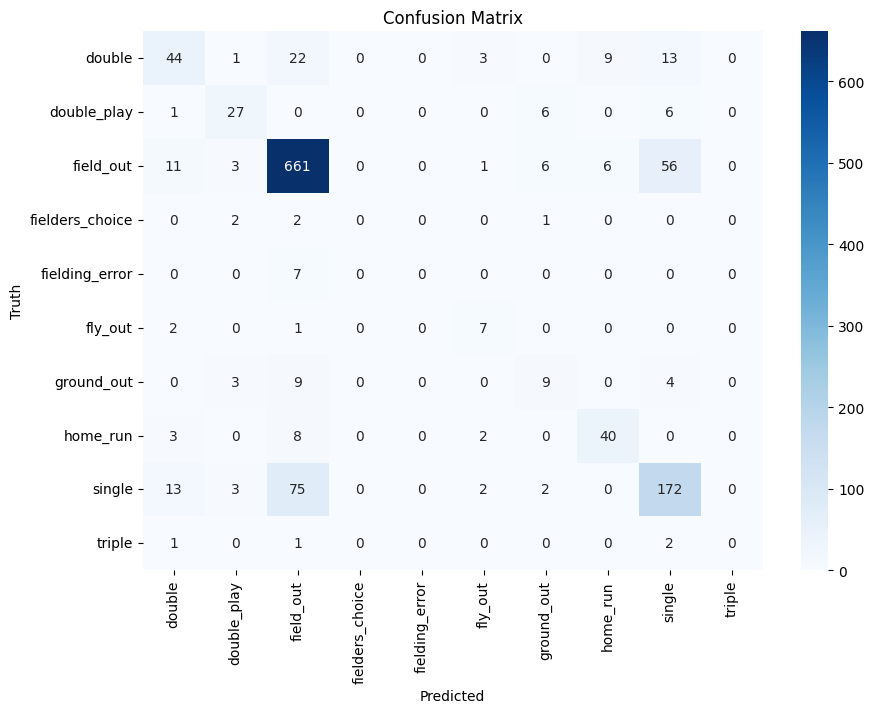

In [197]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_train_coors, clf.predict(X_train_coors)))
print("Accuracy:", accuracy_score(y_test_coors, clf.predict(X_test_coors)))

y_test_lab = encoders['simplified_outcome'].inverse_transform(y_test_coors['simplified_outcome'])
y_pred_lab = encoders['simplified_outcome'].inverse_transform(clf.predict(X_test_coors))

unique_labels = np.unique(np.concatenate((y_test_lab, y_pred_lab)))
cm = confusion_matrix(y_test_lab, y_pred_lab)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
plt.show()

XGB: -778.56, CAT: -1578.31


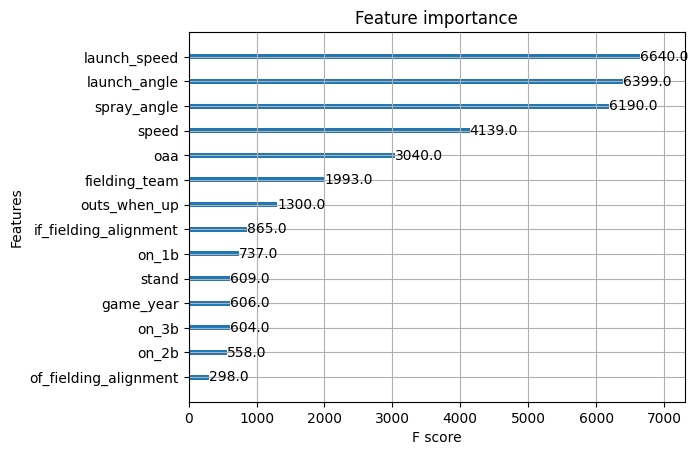

In [198]:
xgb.plot_importance(clf)
def compute_xgboost_loglik(y_pred_proba, y_test, target_col):
    loglik = 0
    for idx, target in enumerate(y_test[target_col]):
        loglik += np.log(y_pred_proba[idx, target])
    return loglik

def compute_cat_loglik(X_train, y_train, y_test, target_col):
    #compute loglike based on categorical distribution using past frequencies

    df = pd.concat([X_train, y_train], axis=1)
    
    pitch_cat_prob = (df[target_col].value_counts() / len(df)) 
    
    loglik = 0
    for target in y_test[target_col]:
        loglik += np.log(pitch_cat_prob.loc[target])
    return loglik

target_col = 'simplified_outcome'
xgb_loglik = compute_xgboost_loglik(clf.predict_proba(X_test_coors), y_test_coors, target_col)
cat_loglik = compute_cat_loglik(X_train_coors, y_train_coors, y_test_coors, target_col)
print(f'XGB: {xgb_loglik:.2f}, CAT: {cat_loglik:.2f}')

In [230]:
t = pd.DataFrame(X_train.iloc[[14]])

t['venue_name'] = [7]
t['launch_angle'] = [30]
t['spray_angle'] = 0
t['launch_speed'] = [95]

np.set_printoptions(suppress=True)
pd.DataFrame(clf.predict_proba(t))

,0,1,2,3,4,5,6,7,8,9,10
0,0.01819,0.000153,0.597704,0.000003,0.005889,0.000026,0.000002,0.354368,0.007197,0.016468,3.170622e-07


In [209]:
np.set_printoptions(suppress=True)
pd.DataFrame(clf.predict_proba(t))

,0,1,2,3,4,5,6,7,8,9,10
0,0.006979,0.492116,0.068346,0.032265,0.004281,0.000001,0.173056,0.000011,0.222711,0.00023,0.000004


In [206]:
pd.DataFrame(encoders['simplified_outcome'].inverse_transform(list(range(11)))).T


,0,1,2,3,4,5,6,7,8,9,10
0,double,double_play,field_out,fielders_choice,fielding_error,fly_out,ground_out,home_run,single,triple,triple_play


XGB: -836.45, CAT: -1460.45


In [123]:
df = query_mlb_db("""
    SELECT
    CASE
        WHEN events IN ('single') THEN 'single'
        WHEN events IN ('double') THEN 'double'
        WHEN events IN ('triple') THEN 'triple'
        WHEN events IN ('home_run') THEN 'home_run'
		WHEN events IN ('field_out') THEN 'field_out'
        WHEN events IN ('ground_out', 'force_out') THEN 'ground_out'
        WHEN events IN ('fly_out', 'sac_fly') THEN 'fly_out'
        WHEN events IN ('double_play', 'grounded_into_double_play', 'sac_fly_double_play') THEN 'double_play'
        WHEN events IN ('triple_play') THEN 'triple_play'
        WHEN events IN ('field_error') THEN 'fielding_error'
        WHEN events IN ('fielders_choice') THEN 'fielders_choice'
        ELSE NULL
    END AS simplified_outcome,
	game_pk, batter,
    case when inning_topbot='Top' then home_team else away_team end as 'fielding_team',
    game_year, outs_when_up, 
	case when on_1b is not null then 1 else 0 end as on_1b,
	case when on_2b is not null then 1 else 0 end as on_2b,
	case when on_3b is not null then 1 else 0 end as on_3b,
	
	if_fielding_alignment, of_fielding_alignment,
	launch_speed, launch_angle, ROUND((-(180 / PI()) * atan2(hc_x - 130, 213 - hc_y) + 90)) as spray_angle
FROM
    Statcast
WHERE type='X'
and 
simplified_outcome &
game_year & outs_when_up & of_fielding_alignment &
launch_speed & launch_angle & spray_angle is not null
ORDER BY GAME_DATE ASC;
""")
df.head()

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0


In [126]:
speed_df = query_mlb_db('select mlb_id as batter, speed from PlayerSpeed;')
speed_df.head()

,batter,speed
0,677951,30.41
1,687363,30.37
2,607208,30.37
3,682829,30.34
4,669352,30.30


In [127]:
oaa_df = query_mlb_db('select * from TeamOAA;')
oaa_df.head()

,year,entity_id,entity_name,oaa_rhh,oaa_lhh,oaa_rhh_standardized,oaa_lhh_standardized
0,2021,108,Angels,-8,-6,-0.986031,-1.104716
1,2022,108,Angels,2,6,0.088866,0.995313
2,2023,108,Angels,0,4,-0.191144,0.873324
3,2024,108,Angels,0,3,-0.052330,0.907826
4,2021,109,D-backs,3,-4,0.300096,-0.710175


In [128]:
venue_df = query_mlb_db('select game_pk, venue_name from VenueGamePkMapping;')
venue_df.head()

,game_pk,venue_name
0,490099,Busch Stadium
1,490106,Tropicana Field
2,490110,Chase Field
3,490098,Citi Field
4,490100,Globe Life Park in Arlington


In [129]:
df = df.merge(venue_df, how='left', on='game_pk')
df

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,747121,518595,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park
831954,ground_out,747121,594807,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park
831955,field_out,747121,671739,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park
831956,field_out,747121,592518,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park


In [130]:
df = df.merge(speed_df, how='left', on='batter')
df['speed'] = df['speed'].astype(float)
df['speed'] = df['speed'].fillna(t['speed'].mean())
df

,simplified_outcome,game_pk,batter,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name,speed
0,single,490099,656941,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium,26.030000
1,single,490099,519203,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium,25.150000
2,double_play,490099,450314,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium,27.301339
3,field_out,490099,451594,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium,27.301339
4,double,490099,649557,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium,27.301339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,747121,518595,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park,26.200000
831954,ground_out,747121,594807,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park,28.160000
831955,field_out,747121,671739,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park,28.990000
831956,field_out,747121,592518,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park,26.350000


In [136]:
df.drop(['batter', 'game_pk'], axis=1)

,simplified_outcome,fielding_team,game_year,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,launch_speed,launch_angle,spray_angle,venue_name,speed
0,single,STL,2017,0,0,0,0,Infield shift,Standard,96.1,18,20.0,Busch Stadium,26.030000
1,single,STL,2017,1,1,0,0,Infield shade,Standard,98.8,16,30.0,Busch Stadium,25.150000
2,double_play,STL,2017,1,1,1,0,Standard,Standard,75.7,1,-14.0,Busch Stadium,27.301339
3,field_out,CHC,2017,0,0,0,0,Standard,Standard,84.9,23,51.0,Busch Stadium,27.301339
4,double,CHC,2017,1,0,0,0,Standard,Standard,102.2,17,47.0,Busch Stadium,27.301339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831953,single,SD,2024,1,1,0,0,Standard,Standard,94.0,10,98.0,Truist Park,26.200000
831954,ground_out,SD,2024,1,1,1,0,Standard,Standard,63.4,-19,114.0,Truist Park,28.160000
831955,field_out,SD,2024,2,1,0,1,Standard,Standard,99.7,-22,65.0,Truist Park,28.990000
831956,field_out,ATL,2024,0,0,0,0,Standard,Standard,92.8,35,85.0,Truist Park,26.350000
